# Further extending MUSE

## Adding a search space filter

In [1]:
from xarray import Dataset, DataArray

from muse.agents import Agent
from muse.filters import register_filter

@register_filter
def no_ccgt_filter(
    agent: Agent,
    search_space: DataArray,
    technologies: Dataset,
    market: Dataset
) -> DataArray:
    """Excludes gasCCGT."""
    dropped_tech = search_space.where(search_space.replacement != "windturbine")
    return search_space & search_space.replacement.isin(dropped_tech.replacement)

In [2]:
import logging
from muse.mca import MCA
from muse import examples

# model_path = examples.copy_model(overwrite=True)
logging.getLogger("muse").setLevel(0)
mca = MCA.factory("model/settings.toml")
mca.run();

-- 2020-11-26 16:43:53 - muse.sectors.register - INFO
Sector legacy registered.

-- 2020-11-26 16:43:53 - muse.sectors.register - INFO
Sector preset registered, with alias presets.

-- 2020-11-26 16:43:53 - muse.sectors.register - INFO
Sector default registered.

-- 2020-11-26 16:43:58 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:44:03 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:44:08 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:44:12 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:44:17 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:44:21 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:44:25 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:44:30 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:44:34 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16

<AxesSubplot:xlabel='year', ylabel='capacity'>

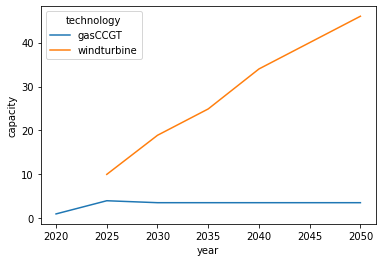

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot

results = pd.read_csv("Results/MCACapacity.csv")
results
sns.lineplot(data=results[results.sector=="power"], x='year', y='capacity', hue='technology')

## Registering a custom decision function

Next, we would like to add an additional decision function. A decision function is a transformation applied to aggregate multiple objectives into a single objective during agent investment. For example, through the use of a weighted sum. 

In this example, we would like to take the median objective. However, the functions predefined in MUSE don't include this functionality. MUSE contains examples such as the mean, weighted sum and a single objective. Therefore we will have to register and create our own.

Now, we create our new `median_objective` function:

In [4]:
from muse.decisions import register_decision
from typing import Any
from xarray import Dataset

@register_decision
def median_objective(
    objectives: Dataset,
    parameters: Any,
    **kwargs
) -> DataArray:
    from xarray import concat
    allobjectives = concat(objectives.data_vars.values(), dim="concat_var")
    return allobjectives.median(set(allobjectives.dims) - {"asset", "replacement"})

After importing the decorator function, `register_decision`, and ensuring that we decorate our new function with  `@register_decision`, we are able to create our new function as above.

Our new function `median_objective` modifies the `mean` function already built into MUSE, with one difference. Replacing the return value, from `allobjectives.mean` to `allobjectives.mean`.

    @register_decision
    def mean(objectives: Dataset, *args, **kwargs) -> DataArray:
        """Mean over objectives."""
        from xarray import concat

        allobjectives = concat(objectives.data_vars.values(), dim="concat_var")
        return allobjectives.mean(set(allobjectives.dims) - {"asset", "replacement"})
        
Of course, you are free to make your functions as complicated as you like, depending on your own requirements.

Next, we must edit our `Agents.csv` file. We will modify the `default` example for this tutorial. We change the first two entry rows, to be as follows:

    Agent1,A1,1,R1,LCOE,NPV,EAC,1,,,FALSE,,,all,median_objective,1,-1,inf,New
    Agent2,A1,2,R1,LCOE,NPV,EAC,1,,,FALSE,,,all,median_objective,1,-1,inf,Retrofit

Here, we add the NPV and EAC decision metrics, as well as replacing the `singleObj` `DecisionMethod` to `median_objective`.

Now we are able to run our modified model as before:

In [5]:
logging.getLogger("muse").setLevel(0)
mca = MCA.factory("../tutorial-code/new-decision-metric/settings.toml")
mca.run();

-- 2020-11-26 16:44:59 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:02 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:04 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:09 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:13 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:17 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:20 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:25 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:28 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:32 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:35 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:39 - muse.mca - WARNING
Check growth constraints for wind.

-- 2020-11-26 16:45:43 - muse.mca - WARN

Again, we visualise the power sector:

<AxesSubplot:xlabel='year', ylabel='capacity'>

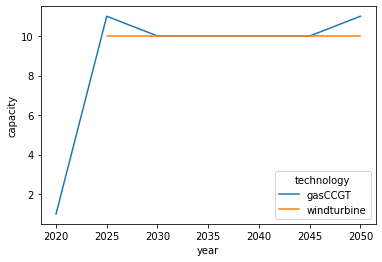

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot

results = pd.read_csv("Results/MCACapacity.csv")
results
sns.lineplot(data=results[results.sector=="power"], x='year', y='capacity', hue='technology')

We see a different scenario emerge through these different decision metrics. This shows the importance of decision metrics when making long-term investment decisions.

## End of tutorials

In these tutorials you have seen the ways in which you can modify MUSE. All of these methods can be combined and extended to make as simple or complex model as you wish. Feel free to experiment and come up with your own ideas for your future work!

For further information, we refer you to the API in the next section.